In [1]:
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv("../../data/preprocessed_AQI_data.csv")
df.head()

,Country,AQI Category,CO AQI Value,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,PM2.5 AQI Value,PM2.5 AQI Category
0,134,2,1,36,0,0,51,2
1,23,0,1,5,0,1,41,0
2,77,2,1,39,0,2,66,2
3,126,0,1,34,0,0,20,0
4,176,2,1,14,0,11,54,2


In [3]:
from sklearn.model_selection import train_test_split

# shuffle the data before splitting
df_shuffled = df.sample(frac=1, random_state=19)
X = df_shuffled.drop(["AQI Category"], axis=1)
y = df_shuffled["AQI Category"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.8, random_state=22
)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(2845, 7) (11384, 7)
(2845,) (11384,)


In [4]:
y.unique()

array([3, 2, 4, 0, 1, 5])

In [5]:
params = {
    "n_neighbors": [2, 3, 5, 7, 9, 11],
    "p": [1, 2],
    "metric": ["cosine", "euclidean", "minkowski"],
}

In [6]:
clf = KNeighborsClassifier(n_neighbors=3, p=2)
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [7]:
clf.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 3,
 'p': 2,
 'weights': 'uniform'}

In [8]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
rep1 = classification_report(y_test, y_pred)
print(rep1)

              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5301
           1       0.93      0.68      0.79        41
           2       0.97      0.97      0.97      4741
           3       0.88      0.98      0.92       618
           4       0.94      0.82      0.87       588
           5       0.78      0.61      0.69        95

    accuracy                           0.97     11384
   macro avg       0.91      0.84      0.87     11384
weighted avg       0.97      0.97      0.96     11384



### Applying grid search

In [9]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=clf, param_grid=params, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(n_neighbors=3),
             param_grid={'metric': ['cosine', 'euclidean', 'minkowski'],
                         'n_neighbors': [2, 3, 5, 7, 9, 11], 'p': [1, 2]},
             scoring='accuracy')

In [10]:
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters: {'metric': 'minkowski', 'n_neighbors': 7, 'p': 1}
Best Accuracy: 0.9750439367311072


In [11]:
best_knn = grid_search.best_estimator_
# Evaluate the best model on the test set
test_accuracy = best_knn.score(X_test, y_test)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9720660576247365


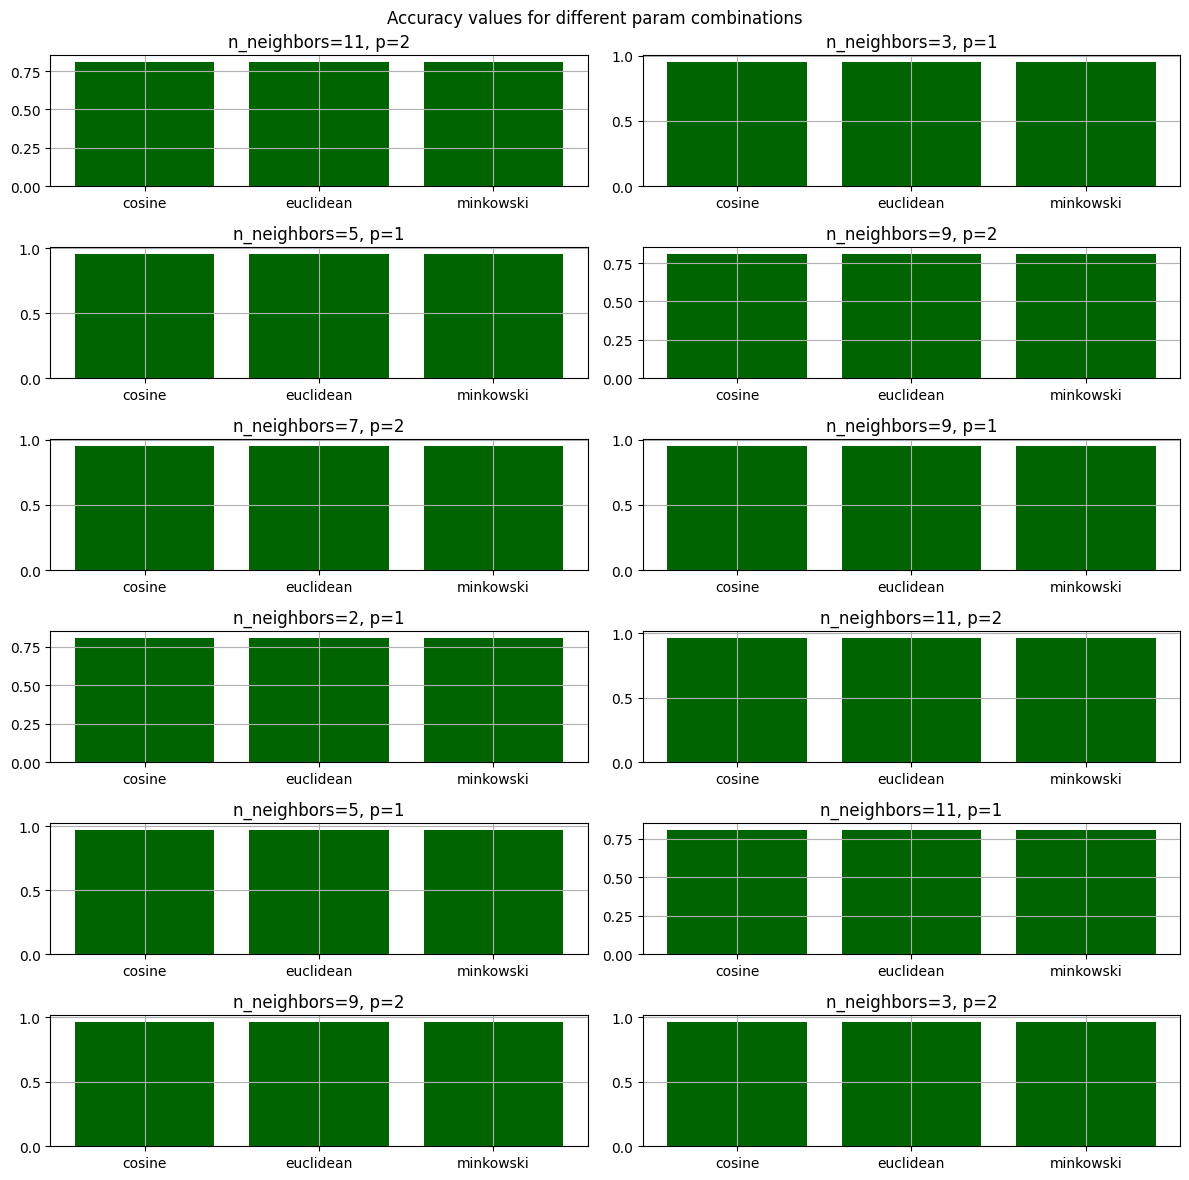

In [12]:
import numpy as np
import matplotlib.pyplot as plt

accuracies = []
param_values = set()
for n_neighbors in params["n_neighbors"]:
    for p in params["p"]:
        for metric in params["metric"]:
            if (n_neighbors, p, metric) not in param_values:
                knn = KNeighborsClassifier(n_neighbors=n_neighbors, p=p, metric=metric)
                knn.fit(X_train, y_train)
                accuracy = knn.score(X_test, y_test)
                accuracies.append(accuracy)
                param_values.add((n_neighbors, p, metric))

# Create subplots based on unique parameter combinations
fig, axs = plt.subplots(len(params["n_neighbors"]), len(params["p"]), figsize=(12, 12))
fig.suptitle("Accuracy values for different param combinations")
for i, ax in enumerate(axs.flat):
    n_neighbors, p, metric = list(param_values)[i]
    ax.bar(
        range(len(params["metric"])),
        accuracies[i :: len(param_values)],
        color="darkgreen",
    )
    ax.set_xticks(range(len(params["metric"])))
    ax.set_xticklabels(params["metric"])
    ax.set_title(f"n_neighbors={n_neighbors}, p={p}")
    ax.grid(True)

plt.tight_layout()
plt.show()

In [13]:
y_preds = best_knn.predict(X_test)
rep2 = classification_report(y_preds, y_test)
print(rep2)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      5340
           1       0.66      0.93      0.77        29
           2       0.98      0.98      0.98      4735
           3       0.99      0.84      0.91       732
           4       0.82      0.97      0.89       499
           5       0.37      0.71      0.49        49

    accuracy                           0.97     11384
   macro avg       0.80      0.90      0.84     11384
weighted avg       0.98      0.97      0.97     11384



## Improving the accuracy

In [14]:
# to do : add scaling of the data
# classificatin report

In [15]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

ss = StandardScaler()  # this gives better results
# mm = MinMaxScaler()

In [16]:
X_train_rescaled = ss.fit_transform(X_train)
X_test_rescaled = ss.fit_transform(X_test)

In [17]:
clf_ = KNeighborsClassifier(n_neighbors=3, p=2)
clf_.fit(X_train_rescaled, y_train)

KNeighborsClassifier(n_neighbors=3)

In [18]:
y_pred = clf_.predict(X_test_rescaled)

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import (
    make_scorer,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
)

# here we define different scorers metrics
scorer_f1 = make_scorer(f1_score, average="weighted")
scorer_precision = make_scorer(precision_score, average="weighted", zero_division=1)
scorer_recall = make_scorer(recall_score, average="weighted")
scorer_accuracy = make_scorer(accuracy_score)

# we save them in a dict for easier accessing
scorers = {
    "f1": scorer_f1,
    "precision": scorer_precision,
    "accuracy": scorer_accuracy,
    "recall": scorer_recall,
}
scores_results: dict = {}
for scorer_name, scorer in scorers.items():
    scores = cross_val_score(clf_, X_train_rescaled, y_train, cv=7, scoring=scorer)
    print(f"{scorer_name.capitalize()} scores:", scores)
    scores_results[scorer_name] = round(scores.mean(), 4)
    print(f"{scorer_name.capitalize()} mean:", round(scores.mean(), 4), "\n")

F1 scores: [0.98841433 0.99151445 0.98743635 0.99046063 0.98849793 0.991997
 0.98561472]
F1 mean: 0.9891 

Precision scores: [0.98982801 0.99347949 0.98877735 0.99159349 0.98964803 0.99349754
 0.988867  ]
Precision mean: 0.9908 

Accuracy scores: [0.99017199 0.99262899 0.98771499 0.99014778 0.99014778 0.99261084
 0.98768473]
Accuracy mean: 0.9902 

Recall scores: [0.99017199 0.99262899 0.98771499 0.99014778 0.99014778 0.99261084
 0.98768473]
Recall mean: 0.9902 



In [20]:
import pandas as pd

scores_df = pd.DataFrame.from_dict(scores_results, orient="index", columns=["Scores"])
scores_df

,Scores
f1,0.9891
precision,0.9908
accuracy,0.9902
recall,0.9902


In [21]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5300
           1       0.54      0.96      0.69        23
           2       1.00      1.00      1.00      4746
           3       0.99      0.89      0.94       682
           4       0.92      0.99      0.95       547
           5       0.73      0.80      0.76        86

    accuracy                           0.99     11384
   macro avg       0.86      0.94      0.89     11384
weighted avg       0.99      0.99      0.99     11384



In [22]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9908643710470836


In [23]:
rep_ = classification_report(y_pred, y_test)
print(rep_)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5300
           1       0.54      0.96      0.69        23
           2       1.00      1.00      1.00      4746
           3       0.99      0.89      0.94       682
           4       0.92      0.99      0.95       547
           5       0.73      0.80      0.76        86

    accuracy                           0.99     11384
   macro avg       0.86      0.94      0.89     11384
weighted avg       0.99      0.99      0.99     11384



In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [25]:
conf_matrix = confusion_matrix(y_pred, y_test)
conf_matrix

array([[5300,    0,    0,    0,    0,    0],
       [   0,   22,    0,    0,    0,    1],
       [   1,    0, 4740,    0,    5,    0],
       [   0,    5,    0,  609,   43,   25],
       [   0,    0,    1,    6,  540,    0],
       [   0,   14,    0,    3,    0,   69]])

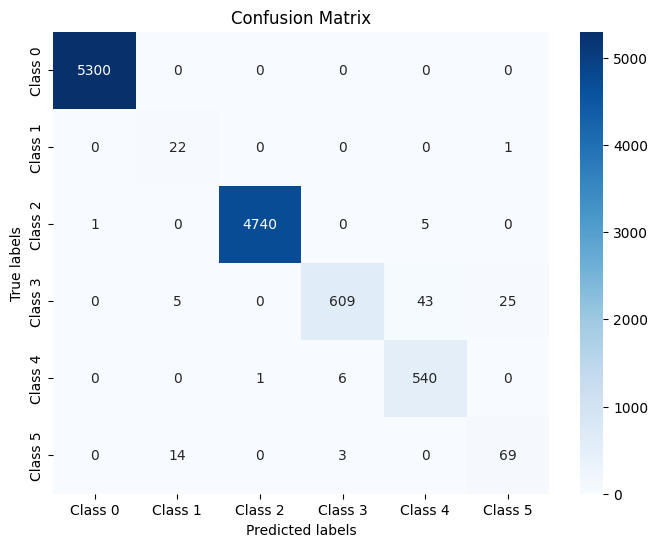

In [26]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
labels = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5"]
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

## Results analysis : 
As we can see, there is still room for imporvement : 
- There are 8 samples that belong to class 5 but were classfied as Class 1
- There are 2 samples that belong to class 0 but were classfiied as Class 2
- THere are 52 samples that belong to Class 4 but were classified as class 3

Let's now try **techniques to mititgate the imbalance** in our dataset 

In [27]:
y_test.value_counts()

AQI Category
0    5301
2    4741
3     618
4     588
5      95
1      41
Name: count, dtype: int64

In [28]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report

In [29]:
# applying smote oversampling for the minority class
smote = SMOTE(random_state=0)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_rescaled, y_train)

Let's now check the data distributoin after resampling

In [30]:
y_train_resampled.value_counts()

AQI Category
0    1369
2    1369
3    1369
5    1369
4    1369
1    1369
Name: count, dtype: int64

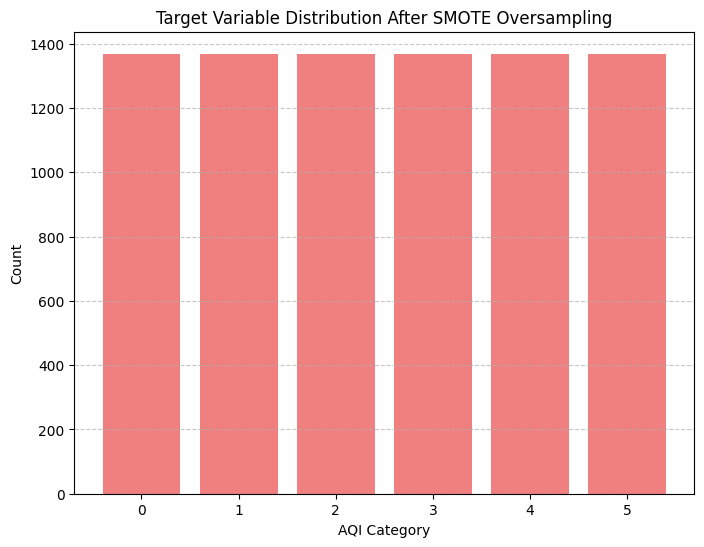

In [31]:
unique_classes, class_counts = np.unique(y_train_resampled, return_counts=True)

plt.figure(figsize=(8, 6))
plt.bar(unique_classes, class_counts, color="lightcoral")
plt.title("Target Variable Distribution After SMOTE Oversampling")
plt.xlabel("AQI Category")
plt.ylabel("Count")
plt.xticks(unique_classes)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

In [32]:
knn = KNeighborsClassifier(n_neighbors=3, p=2, metric="cosine")
knn.fit(X_train_resampled, y_train_resampled)

KNeighborsClassifier(metric='cosine', n_neighbors=3)

In [33]:
y_pred = knn.predict(X_test_rescaled)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5301
           1       0.88      0.73      0.80        41
           2       1.00      0.98      0.99      4741
           3       0.89      0.91      0.90       618
           4       0.92      0.96      0.94       588
           5       0.59      0.83      0.69        95

    accuracy                           0.98     11384
   macro avg       0.88      0.90      0.89     11384
weighted avg       0.98      0.98      0.98     11384



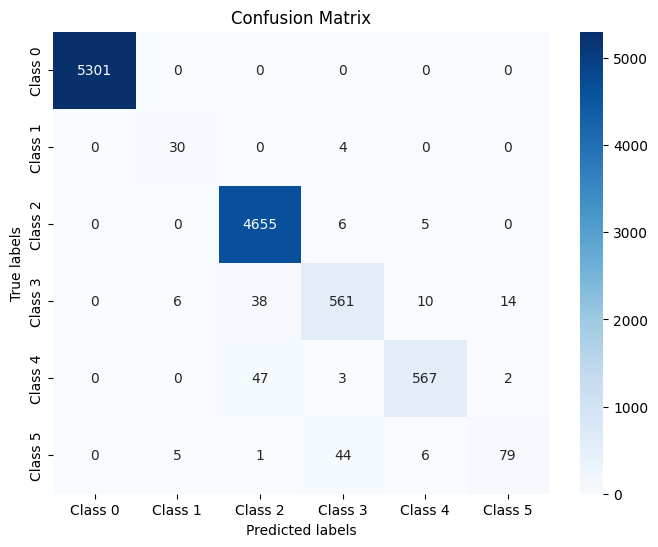

In [34]:
conf_matrix_ = confusion_matrix(y_pred, y_test)
plt.figure(figsize=(8, 6))
labels = ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4", "Class 5"]
sns.heatmap(
    conf_matrix_,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels,
    yticklabels=labels,
)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

In [35]:
accuracy_ = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy_)

Accuracy: 0.9832220660576247


In this case, using undersampling does not help improve the model's classification metrics